In [1]:
'''--------------------------------------------------------------------------
=========                 |
\\      /  F ield         | OpenFOAM: Addition to OpenFOAM v6
 \\    /   O peration     | Website:  https://github.com/StasF1/intakePipe
  \\  /    A nd           | Copyright (C) 2018-2020 Stanislau Stasheuski
   \\/     M anipulation  |
------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.
    
    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.
    
    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

File
    postProcess.ipynb

Description
    Post-process results to get discharge coefficient and swirl number
    for different valve strokes

---------------------------------------------------------------------------'''
import os, re, imp, warnings
import numpy as np
import matplotlib.pyplot as plt

from math import pi
imp.load_source('projectDict', f'{os.getcwd()}/projectDict')
from projectDict import *

In [2]:
filterwarnings = 'ignore' # 'once' or 'ingore'
warnings.filterwarnings(filterwarnings)

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

&lt;IPython.core.display.HTML object&gt;

In [3]:
''' Functions initialision '''

sind = lambda x : np.sin(np.deg2rad(x))
cosd = lambda x : np.cos(np.deg2rad(x))
tand = lambda x : np.tan(np.deg2rad(x))

def grep_by_name(file_path, value_name):
    ''' Get value from file after its word definition
    '''
    for grep in open(file_path):
        if value_name in grep:
            value = (re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?', grep))[0]

    return float(value)

def Dc(Dn):
    ''' Convert Dn swirl number into Dc
    '''
    return pi/2*PISTON_BORE/PISTON_STROKE*np.array(Dn)

In [4]:
''' Convert to metres '''
PISTON_STROKE *= 1e-3
PISTON_BORE *= 1e-3
D_PIPE *= 1e-3
D_2PIPE *= 1e-3
D_1 *= 1e-3
D_2 *= 1e-3
D_BAR *= 1e-3

In [5]:
''' Get data from the .dat files '''

# Valve stroke list
stroke = np.arange(STROKE_INIT,
                   STROKE_FINITE + STROKE_STEP,
                   STROKE_STEP)

dt = {} # data dictionary
for n in range(DESIGN_NO + 1):

    dt[f'design{n}'] = {}
    for h in range(len(stroke)):
        dt[f'design{n}'][f'h{stroke[h]*1e-3}'] = {}
        
        post_path = f'{os.getcwd()}/design{n}/stroke_{stroke[h]}mm/postProcessing'
        
        dt[f'design{n}'][f'h{stroke[h]*1e-3}']['inlet'] = {
            'p': np.loadtxt(f'{post_path}/patchAverage(p,static(p),total(p),mag(U),name=inlet)/0/surfaceFieldValue.dat')[1],
            'U': np.loadtxt(f'{post_path}/patchAverage(p,static(p),total(p),mag(U),name=inlet)/0/surfaceFieldValue.dat')[4],
            'phi': abs(np.loadtxt(f'{post_path}/flowRatePatch(name=inlet)/0/surfaceFieldValue.dat')[1]),
        }

        for c in range(5):
            dt[f'design{n}'][f'h{stroke[h]*1e-3}'][f'c{c}'] = {
                'L': np.loadtxt(f'{post_path}/volIntegrateMagAngularMomentum(name=c{c})/0/volFieldValue.dat')[1],
                'v_c': grep_by_name(f'{post_path}/volIntegrateMagAngularMomentum(name=c{c})/0/volFieldValue.dat', 'Volume'),
            }

# Convert stroke list to metres
stroke = stroke*1e-3 #[m]

In [6]:
''' Common plot parameters '''
figsize = 6
figsize_xy_ratio = 1.2
fontsize = 12
linewidth = 2

Cut type for stroke 2 mm: II
Cut type for stroke 3 mm: III
Cut type for stroke 4 mm: III
Cut type for stroke 5 mm: III
Cut type for stroke 6 mm: III
Cut type for stroke 7 mm: III
Cut type for stroke 8 mm: III
Cut type for stroke 9 mm: III
Cut type for stroke 10 mm: III


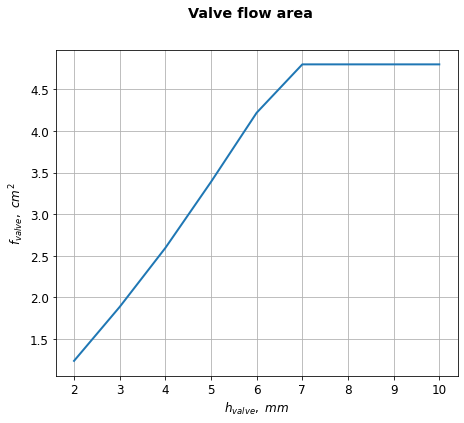

In [7]:
''' Minimal inlet area '''

h_crI, h_crII = (D_PIPE - D_1)/sind(2*THETA), (D_2PIPE - D_1)/sind(2*THETA)

#- Minimal pipe area
critical_area = pi*D_PIPE**2/4 - pi*D_BAR**2/4

valve_flow_area = []
for h in range(len(stroke)):
    if (stroke[h] <= h_crI):
        ''' Cut I '''
        cut='I'
        valve_flow_area.append(
            pi*stroke[h]
            *cosd(THETA)
            *(D_PIPE - stroke[h]*sind(THETA)*cosd(THETA)))

    elif (stroke[h] > h_crI) and (stroke[h] <= h_crII):
        ''' Cut II '''
        cut='II'
        valve_flow_area.append(
            pi*stroke[h]
            *cosd(THETA)
            *(D_1 + stroke[h]*sind(THETA)*cosd(THETA)))

    else:
        ''' Cut III '''
        cut='III'
        valve_flow_area.append(
            pi/4
            *(D_2PIPE + D_1)
            *np.sqrt(pow(D_2PIPE - D_1, 2)
                     + pow(2*stroke[h] - (D_2PIPE - D_1)*tand(THETA), 2)))

    print(f'Cut type for stroke {int(stroke[h]*1e+03)} mm: {cut}')

    if (valve_flow_area[h] > critical_area):
        valve_flow_area[h] = critical_area

plt.figure(figsize=[figsize*figsize_xy_ratio, figsize])\
   .suptitle('Valve flow area',
             fontweight='bold',
             fontsize=fontsize*figsize_xy_ratio)

plt.plot(stroke*1e+3, #[mm]
         np.array(valve_flow_area)*1e+4, #[cm]
         linewidth=linewidth)
plt.grid(True)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('$h_{valve},\ mm$', fontsize=fontsize)
plt.ylabel('$f_{valve},\ cm^2$', fontsize=fontsize)

# Create postProcessing/ folder for a whole project
if not os.path.exists(f'{os.getcwd()}/postProcessing'):
    os.makedirs(f'{os.getcwd()}/postProcessing')

plt.savefig(f'{os.getcwd()}/postProcessing/f.png')

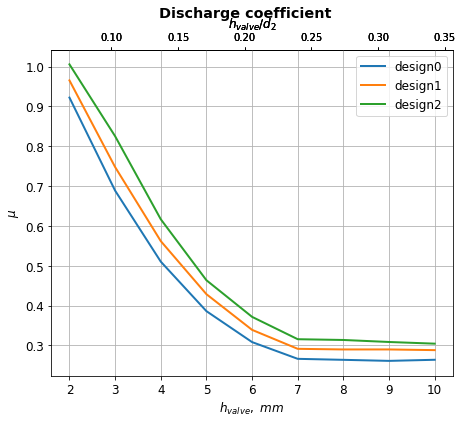

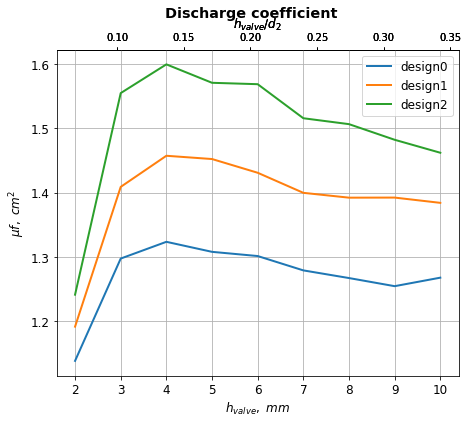

In [8]:
''' Discharge coefficient '''

plt.figure(figsize=[figsize*figsize_xy_ratio, figsize])\
   .suptitle('Discharge coefficient',
             fontweight='bold',
             fontsize=fontsize*figsize_xy_ratio)

def real2rel(h):
    return h*1e-3/D_2
def rel2real(h):
    return h*1e+3*D_2

for n in range(DESIGN_NO + 1):

    dt[f'design{n}']['mu'] = []
    for h in range(len(stroke)):
        dt[f'design{n}']['mu'].append(
            dt[f'design{n}'][f'h{stroke[h]}']['inlet']['phi']
            /valve_flow_area[h]
            /np.sqrt(2*dt[f'design{n}'][f'h{stroke[h]}']['inlet']['p']
                     + dt[f'design{n}'][f'h{stroke[h]}']['inlet']['U']**2)
        )

    plt.plot(stroke*1e+3,
             dt[f'design{n}']['mu'],
             linewidth=linewidth,
             label=f'design{n}')

    plt.subplot()\
       .secondary_xaxis('top', functions=(real2rel, rel2real))\
       .set_xlabel('$h_{valve}/d_2$', fontsize=fontsize)

    plt.grid(True)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    plt.xlabel('$h_{valve},\ mm$', fontsize=fontsize)
    plt.ylabel('$\mu$', fontsize=fontsize)
plt.savefig(f'{os.getcwd()}/postProcessing/mu.png')


plt.figure(figsize=[figsize*figsize_xy_ratio, figsize])\
   .suptitle('Discharge coefficient',
             fontweight='bold',
             fontsize=fontsize*figsize_xy_ratio)

for n in range(DESIGN_NO + 1):

    plt.plot(stroke*1e+3,
             dt[f'design{n}']['mu']*np.array(valve_flow_area)*1e+04,
             linewidth=linewidth,
             label=f'design{n}')

    plt.subplot()\
       .secondary_xaxis('top', functions=(real2rel, rel2real))\
       .set_xlabel('$h_{valve}/d_2$', fontsize=fontsize)

    plt.grid(True)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    plt.xlabel('$h_{valve},\ mm$', fontsize=fontsize)
    plt.ylabel('$\mu f,\ cm^2$', fontsize=fontsize)
plt.savefig(f'{os.getcwd()}/postProcessing/muf.png')

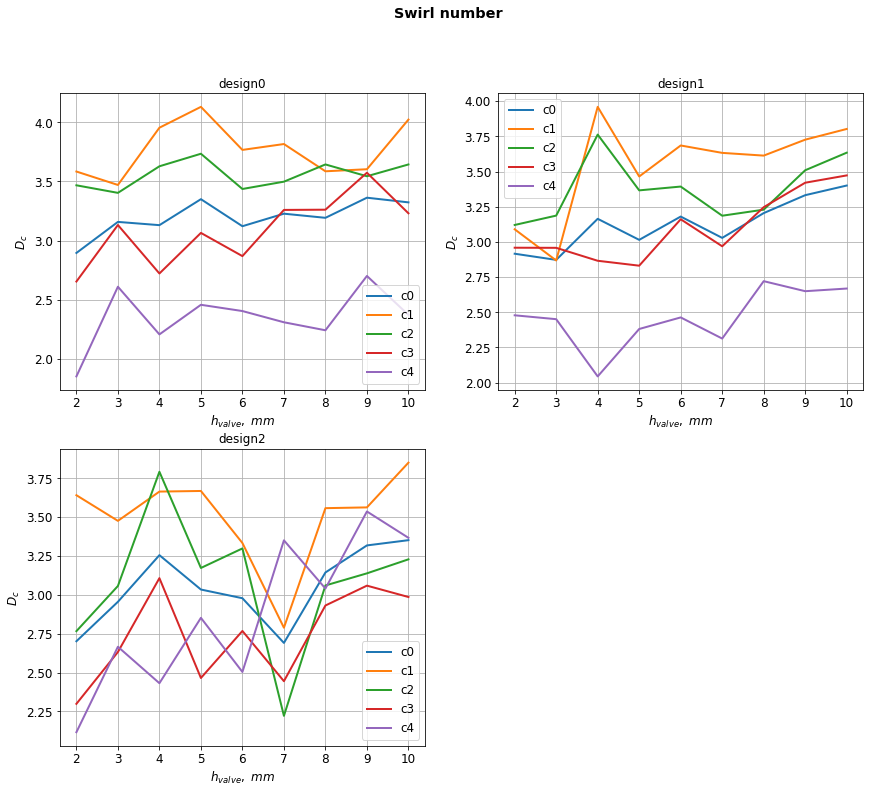

In [9]:
''' Swirl number by design '''

plt.figure(figsize=[figsize*figsize_xy_ratio*2, figsize*2])\
   .suptitle('Swirl number',
             fontweight='bold',
             fontsize=fontsize*figsize_xy_ratio)

for n in range(DESIGN_NO + 1):

    plt.subplot(221 + n).set_title(f'design{n}')
    for c in range(5):

        Dn = []
        for h in range(len(stroke)):
            dt[f'design{n}'][f'h{stroke[h]}'][f'c{c}']['Dn'] = (
                2*PISTON_STROKE*rhoInf
                *dt[f'design{n}'][f'h{stroke[h]}'][f'c{c}']['L']
                /dt[f'design{n}'][f'h{stroke[h]}']['inlet']['phi']
                /dt[f'design{n}'][f'h{stroke[h]}'][f'c{c}']['v_c']
            )
            Dn.append(dt[f'design{n}'][f'h{stroke[h]}'][f'c{c}']['Dn'])

        plt.plot(stroke*1e+3,
                 # stroke/D_2,
                 Dc(Dn),
                 linewidth=2,
                 label=f'c{c}')

    plt.grid(True)
    plt.legend(loc='best', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('$h_{valve},\ mm$', fontsize=fontsize)
    # plt.xlabel('$h_{valve}/d_2$', fontsize=fontsize)
    plt.ylabel('$D_c$', fontsize=fontsize)
plt.savefig(f'{os.getcwd()}/postProcessing/Dc(design).png')

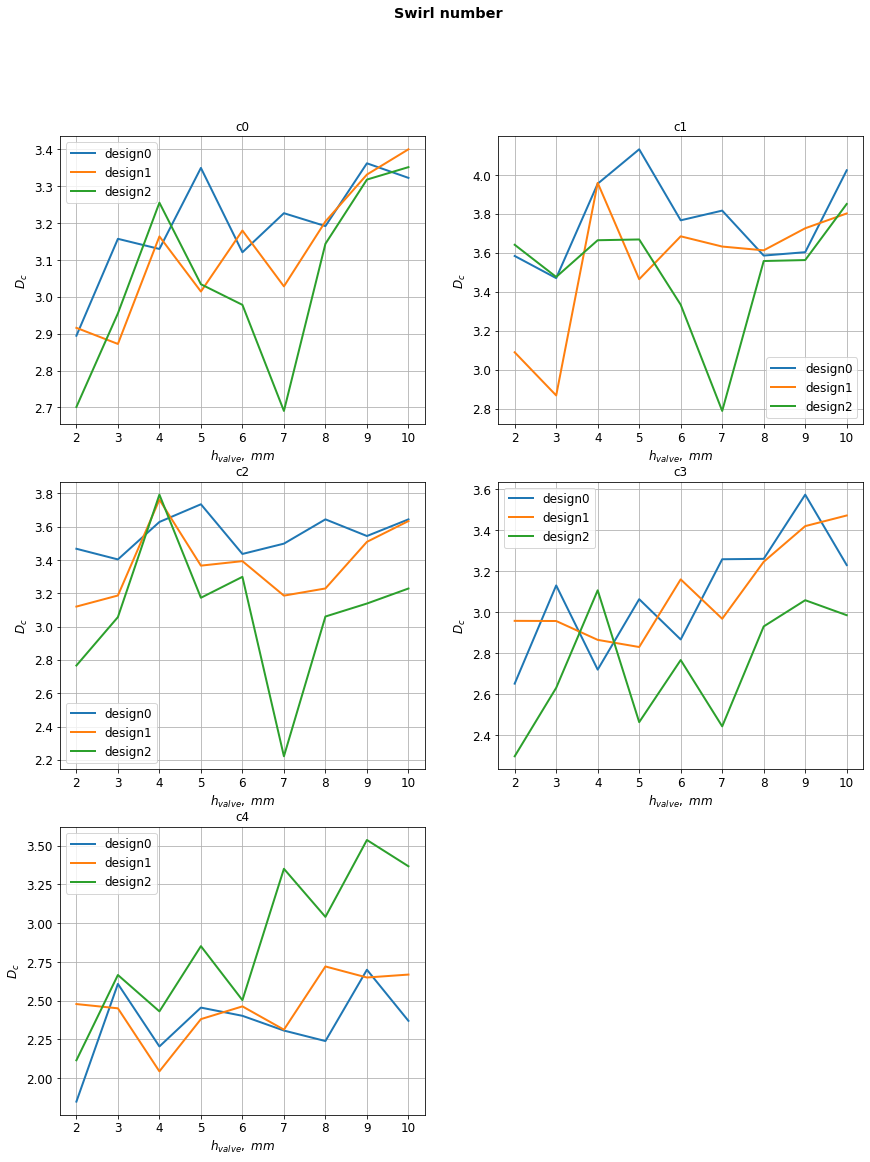

In [10]:
''' Swirl number by cylinder '''

plt.figure(figsize=[figsize*figsize_xy_ratio*2, figsize*3])\
   .suptitle('Swirl number',
             fontweight='bold',
             fontsize=fontsize*figsize_xy_ratio)

for c in range(5):
    plt.subplot(321 + c).set_title(f'c{c}')

    for n in range(DESIGN_NO + 1):

        Dn = []
        for h in range(len(stroke)):
            Dn.append(dt[f'design{n}'][f'h{stroke[h]}'][f'c{c}']['Dn'])

        plt.plot(stroke*1e+3,
                 # stroke/D_2,
                 Dc(Dn),
                 linewidth=2,
                 label=f'design{n}')

    plt.grid(True)
    plt.legend(loc='best', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('$h_{valve},\ mm$', fontsize=fontsize)
    # plt.xlabel('$h_{valve}/d_2$', fontsize=fontsize)
    plt.ylabel('$D_c$', fontsize=fontsize)
plt.savefig(f'{os.getcwd()}/postProcessing/Dc(c).png')

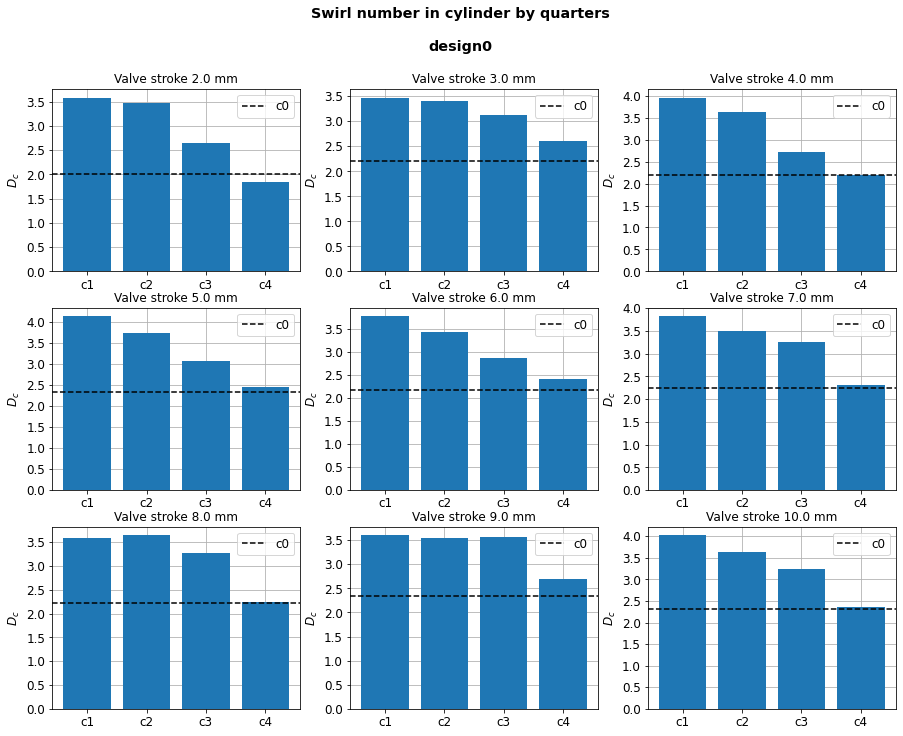

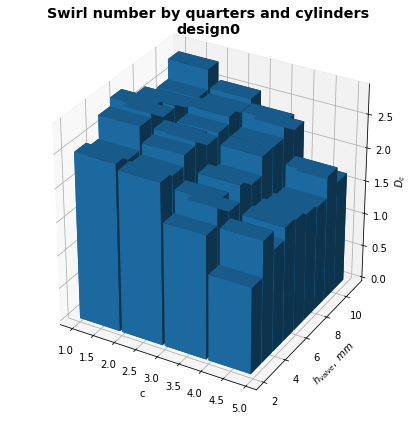

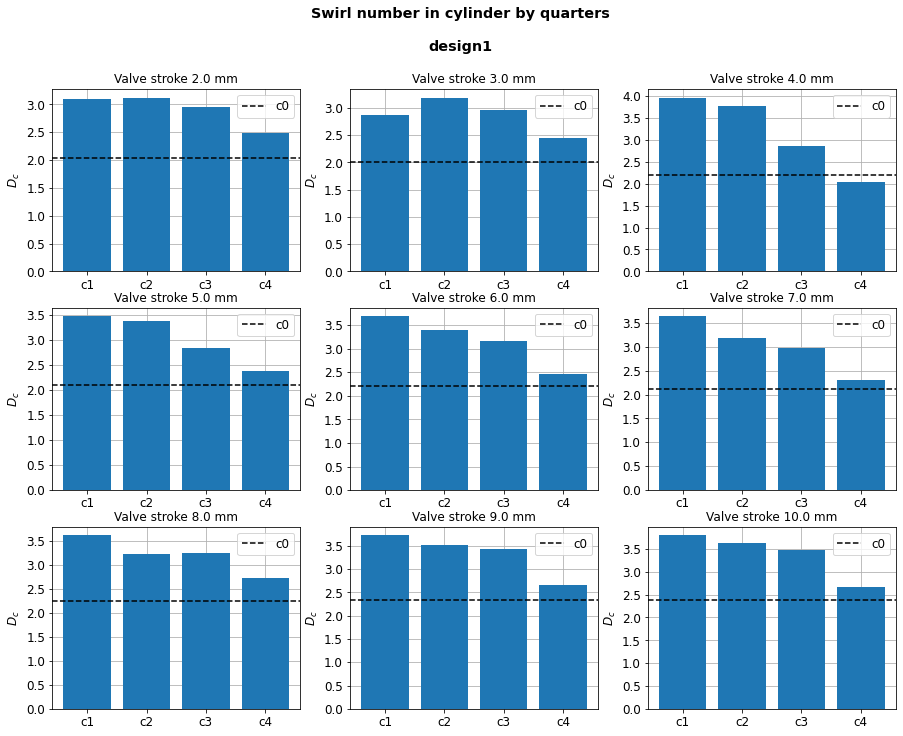

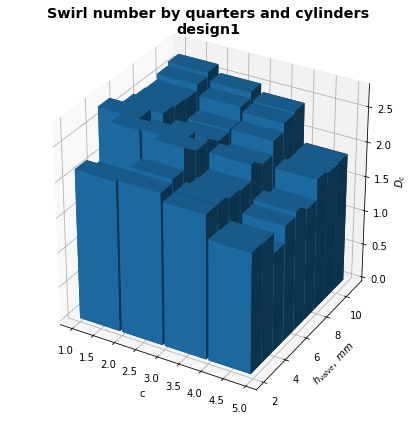

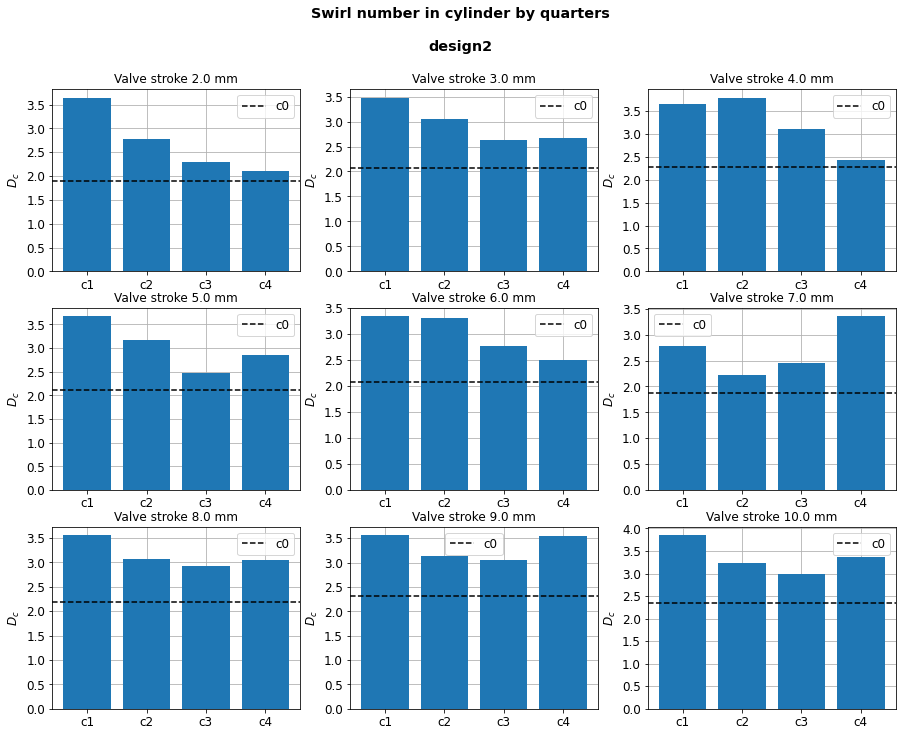

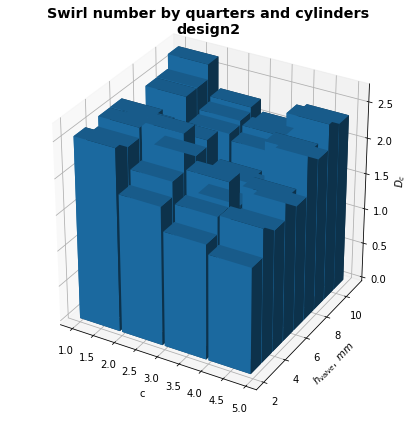

In [11]:
''' Swirl number by stroke '''

c_labels = ['c1', 'c2', 'c3', 'c4']

for n in range(DESIGN_NO + 1):
    # 2D bar plot array
    plt.figure(figsize=[figsize*figsize_xy_ratio*2.1, figsize*1.9])\
       .suptitle(f'Swirl number in cylinder by quarters\n\ndesign{n}',
                 fontweight='bold',
                 fontsize=fontsize*figsize_xy_ratio)
    Dn_h = []    
    for h in range(len(stroke)):
        plt.subplot(331 + h).set_title(f'Valve stroke {round(stroke[h]*1e+3, 1)} mm')
        
        Dn = []
        for c in range(1, len(c_labels) + 1):
            Dn.append(dt[f'design{n}'][f'h{stroke[h]}'][f'c{c}']['Dn'])
        Dn_h.append(np.array(Dn))

        plt.bar(
            range(len(Dn)), Dc(Dn),
            zorder=2
        )
        plt.axhline(y=dt[f'design{n}'][f'h{stroke[h]}'][f'c0']['Dn'],
                    linestyle='--',
                    color='black',
                    label='c0',
                    zorder=2)

        plt.grid(True, zorder=0)
        plt.legend(loc='best', fontsize=fontsize)
        plt.xticks(range(len(Dn)), c_labels, fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.ylabel('$D_c$', fontsize=fontsize)
    plt.savefig(f'{os.getcwd()}/design{n}/Dc(h).png')

    # 3D bar plot
    fig = plt.figure(figsize=[figsize*figsize_xy_ratio, figsize*1.25])
    ax = fig.add_subplot(projection='3d')
    ax.set_title(f'Swirl number by quarters and cylinders\ndesign{n}',
                fontweight='bold',
                fontsize=fontsize*figsize_xy_ratio)

    _x, _y = np.meshgrid(np.arange(1, len(c_labels) + 1), stroke*1e+3)
    x, y = _x.ravel(), _y.ravel()

    ax.bar3d(x, y, np.zeros_like(x + y), 0.95, STROKE_STEP*0.95,
             (np.array(Dn_h)).flatten(),
             shade=True)

    ax.set_xlabel('c')
    ax.set_ylabel('$h_{valve},\ mm$')
    ax.set_zlabel('$D_c$')

    plt.savefig(f'{os.getcwd()}/design{n}/Dc(c,h).png')